## DE with MAST - bcells DE Stents
### based on https://github.com/theislab/single-cell-tutorial

In [15]:
import scanpy as sc
import numpy as np
import pandas as pd
import os, sys, string
import seaborn as sns

sc.set_figure_params(vector_friendly=False, fontsize=18)

import pandas as pd
import numpy as np

import anndata
from scipy.io import mmwrite

import matplotlib.pyplot as plt
from collections import Counter

from typing import Tuple, Union, List, Dict, Callable
import os
import gzip
import shutil
import inspect
import h5py

import matplotlib.pyplot as plt
%matplotlib inline


import rpy2.rinterface_lib.callbacks
import logging
import matplotlib

from rpy2.robjects import pandas2ri
import anndata2ri

import rpy2.robjects as ro
sys.path.insert(0, "/Users/noamibrahimhayat/Documents/Aachen/projects/commons/")

In [3]:
matplotlib.rcParams['pdf.fonttype'] = 42

In [4]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.8.1
sinfo       0.3.4
-----
PIL                         8.4.0
anndata2ri                  1.0.6
appnope                     0.1.2
asciitree                   NA
backcall                    0.2.0
bottleneck                  1.3.2
certifi                     2022.06.15
cffi                        1.15.1
charset_normalizer          2.0.12
cloudpickle                 2.1.0
colorama                    0.4.5
cycler                      0.10.0
cython_runtime              NA
dask 

In [5]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(ggplot2)
library(plyr)
library(MAST)

In [6]:
def makedirs(dirpath):
    if not os.path.exists(dirpath):
        os.system("mkdir "+ dirpath)

In [7]:
home      = "/Users/shayat/Documents/Aachen/projects/stents//"
datahome  = home+ "data/"
resulthome= home+ "results/"

In [8]:
makedirs(home)
makedirs(datahome)
makedirs(resulthome)

In [9]:
## Chose input file
filename2  = "scvi_output.h5ad" ## 32k cells sikander

## main clusters
cluster_file= "stents_scvi_output_clustered.h5ad"
cluster_file= "scvi_output_clustered_markers.h5ad"

## subcluster file
cluster_file="stents_Bcells_0.3subcluster.h5ad"

In [10]:
cluster_file

'stents_Bcells_0.3subcluster.h5ad'

## Read data

In [11]:
adata = sc.read_h5ad(datahome+cluster_file)

In [12]:
adata

AnnData object with n_obs × n_vars = 2009 × 16129
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.1', 'seurat_clusters', 'cc', 'integrated_snn_res.0.2', 'cell_type', 'cluster', 'ident', 'scvi_batch', 'scrublet', 'n_counts', 'n_genes', 'scvi_library_size', 'solo_singlet_logit_prob', 'solo_doublet_logit_prob', 'subcluster'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'X_name', 'cc_colors', 'cell_type_colors', 'hvg', 'ident_colors', 'leiden', 'leiden0.3_colors', 'neighbors', 'orig.ident_colors', 'rank_genes_groups0.3', 'rank_genes_groups_subcluster', 'scvi_elbo_train', 'scvi_elbo_validation', 'scvi_kl_global_train', 'scvi_kl_global_validation', 'scvi_kl_local_train', 'scvi_kl_local_validation', 'scvi_reconstruction_loss_train', 'scvi_reconstruction_loss_validation', 'scvi_train_loss_epoch', 'scvi_train_loss_step', 'scvi_validation_loss', 'subcluster_colors'
    obsm: 'PCA',

In [13]:
adata.obs.head()

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.1,seurat_clusters,cc,integrated_snn_res.0.2,cell_type,cluster,ident,scvi_batch,scrublet,n_counts,n_genes,scvi_library_size,solo_singlet_logit_prob,solo_doublet_logit_prob,subcluster
AAACCCAAGAACTTCC-1,pbmc3k,3898.0,1296,5.977424,0,0,case,0,B-cell,B-cell,case,0,0.127273,3898.0,1296,1.842570,2.298886,-2.189409,1
AAACGAAAGCCAAGTG-1,pbmc3k,5069.0,1531,8.640758,0,0,case,0,B-cell,B-cell,case,0,0.098845,5069.0,1531,1.665068,3.979088,-4.268512,0
AAACGAAAGCTCAGAG-1,pbmc3k,2776.0,994,9.113833,0,0,case,0,B-cell,B-cell,case,0,0.092251,2776.0,994,1.631147,9.088346,-9.264715,0
AAACGAAGTTTACGTG-1,pbmc3k,1727.0,727,9.901563,0,0,case,0,B-cell,B-cell,case,0,0.092251,1727.0,727,1.661136,18.495361,-18.370918,0
AAACGCTTCCGCTAGG-1,pbmc3k,2314.0,1055,8.383751,0,0,case,0,B-cell,B-cell,case,0,0.017370,2314.0,1055,2.152620,5.658727,-5.221175,2


In [13]:
Counter(adata.obs["cc"])

Counter({'case': 1887, 'control': 134})

In [14]:
#  Custer naming
res = 0.1

cluster_names = {'0': '0 : Bcells',
'1':'1 : Tcell',
'2':'2 : Fibroblast',
'3':'3 : Endothelial',
'4':'4 : Macrophage',
'5':'5 : VSMC',
'6':'6 : NKcells',
'7':'7 : Neutrophils',
'8':'8 : Neuronal'     }

#adata.obs['leiden' + str(res)] = adata.obs['leiden' + str(res)].apply(lambda s: cluster_names[s])

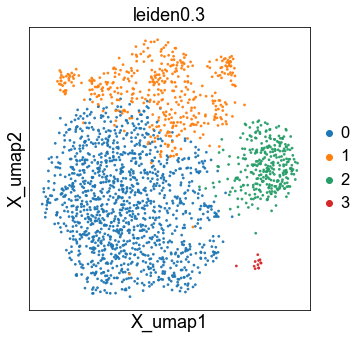

In [16]:
# check out how it looks by sample
plt.figure(figsize=(5, 5))
sc.pl.embedding(adata, basis='X_umap', color='leiden0.3', ax=plt.gca(), size=30, alpha=0.95)

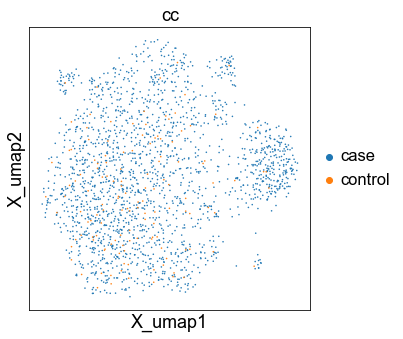

In [17]:
# check out how it looks by sample
plt.figure(figsize=(5, 5))
sc.pl.embedding(adata, basis='X_umap', color='cc', ax=plt.gca(), size=10, alpha=0.95)

In [18]:
Counter(adata.obs["cc"])

Counter({'case': 1887, 'control': 134})

In [20]:
adata.obs[["cell_type", "cluster", "leiden0.3"]].drop_duplicates()

,cell_type,cluster,leiden0.3
AAACCCAAGAACTTCC-1,B-cell,B-cell,1
AAACGAAAGCCAAGTG-1,B-cell,B-cell,0
AAACGCTTCCGCTAGG-1,B-cell,B-cell,2
AAGACAATCCGCGAGT-1,B-cell,B-cell,3
AATGCCATCATTGTTC-1,Macrophage,Macrophage,2
ACTTAGGGTTCAGGTT-1,Endothelial2,Endothelial2,0
AGGGCTCCATCAACCA-1,VSMC,VSMC,1
CCTTGTGTCGCCTCTA-1,T-cell,T-cell,3
GAGACTTTCATTACTC-1,Macrophage,Macrophage,3
GTGCTTCCACTGGAAG-1,VSMC,VSMC,2


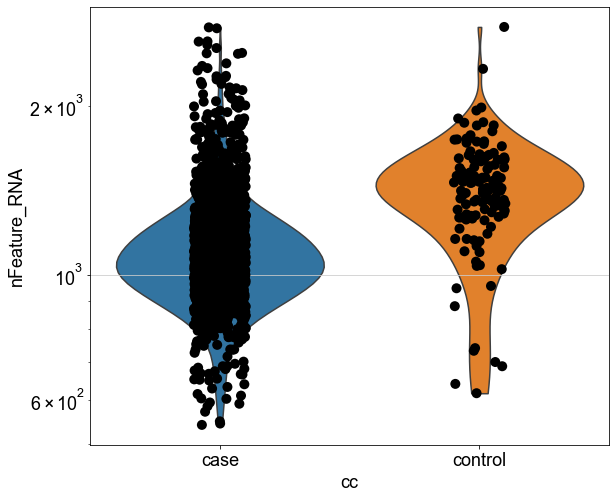

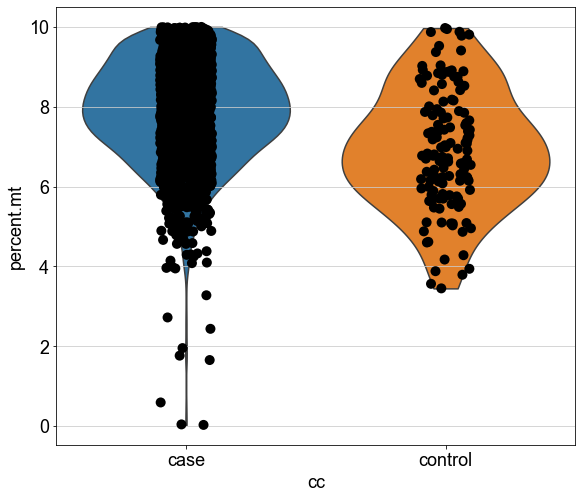

In [21]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, 'nFeature_RNA', groupby='cc', size=10, log=True, cut=0)
t3 = sc.pl.violin(adata, 'percent.mt', groupby='cc', size=10)

In [23]:
myclusters = adata.obs["leiden0.3"].drop_duplicates().values.tolist()

In [25]:
for clust_id in myclusters:
    tmp_adata = adata[adata.obs["leiden0.3"]==clust_id].copy()
    print(clust_id, tmp_adata.shape, Counter(tmp_adata.obs["cc"]))

1 (429, 16129) Counter({'case': 413, 'control': 16})
0 (1270, 16129) Counter({'case': 1159, 'control': 111})
2 (310, 16129) Counter({'case': 304, 'control': 6})
3 (12, 16129) Counter({'case': 11, 'control': 1})


## DE genes wrt different conditions

In [26]:
adata.obs.head(2)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.1,seurat_clusters,cc,integrated_snn_res.0.2,cell_type,cluster,ident,scvi_batch,scrublet,n_counts,n_genes,scvi_library_size,solo_singlet_logit_prob,solo_doublet_logit_prob,leiden0.3
AAACCCAAGAACTTCC-1,pbmc3k,3898.0,1296,5.977424,0,0,case,0,B-cell,B-cell,case,0,0.127273,3898.0,1296,1.842570,2.298886,-2.189409,1
AAACGAAAGCCAAGTG-1,pbmc3k,5069.0,1531,8.640758,0,0,case,0,B-cell,B-cell,case,0,0.098845,5069.0,1531,1.665068,3.979088,-4.268512,0


In [27]:
myclusters = adata.obs["leiden0.3"].drop_duplicates().values.tolist()

In [28]:
print(myclusters)

['1', '0', '2', '3']


In [29]:
cl1= adata.copy()

In [30]:
#Create new Anndata object for use in MAST with non-batch corrected data as before
adata_test   = cl1.copy()
adata_test.X = cl1.X
adata_test.obs['n_genes'] = np.array((adata_test.X > 0).sum(1)).flatten()

In [31]:
cl1

AnnData object with n_obs × n_vars = 2021 × 16129
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.1', 'seurat_clusters', 'cc', 'integrated_snn_res.0.2', 'cell_type', 'cluster', 'ident', 'scvi_batch', 'scrublet', 'n_counts', 'n_genes', 'scvi_library_size', 'solo_singlet_logit_prob', 'solo_doublet_logit_prob', 'leiden0.3'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'X_name', 'cc_colors', 'cell_type_colors', 'hvg', 'ident_colors', 'leiden', 'leiden0.3_colors', 'neighbors', 'orig.ident_colors', 'rank_genes_groups0.3', 'scvi_elbo_train', 'scvi_elbo_validation', 'scvi_kl_global_train', 'scvi_kl_global_validation', 'scvi_kl_local_train', 'scvi_kl_local_validation', 'scvi_reconstruction_loss_train', 'scvi_reconstruction_loss_validation', 'scvi_train_loss_epoch', 'scvi_train_loss_step', 'scvi_validation_loss'
    obsm: 'PCA', 'UMAP', 'X_pca_harmony', 'X_scvi', 'X_scvi_umap', 'X_

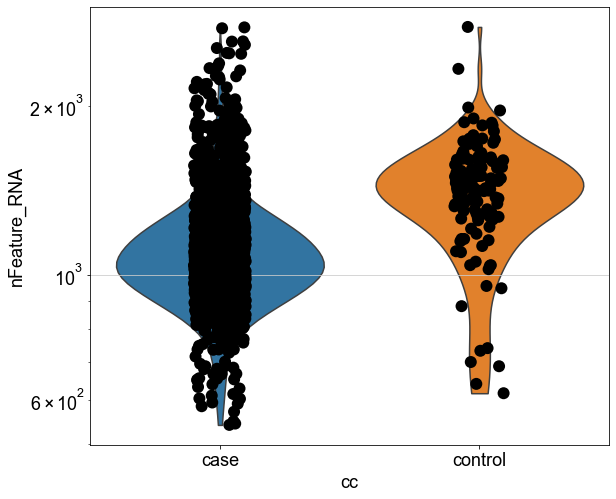

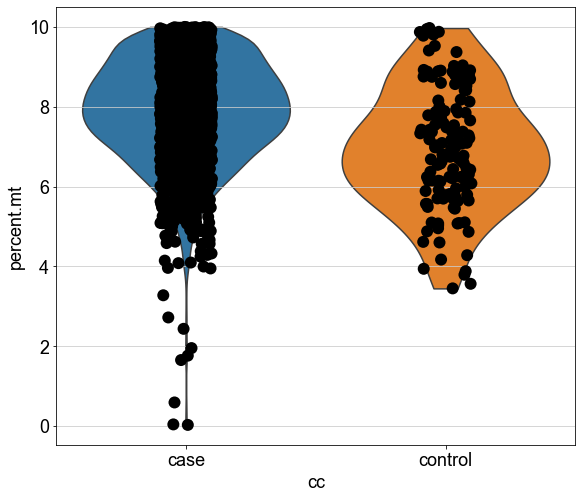

In [32]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata_test, 'nFeature_RNA', groupby='cc', size=12, log=True, cut=0)
t3 = sc.pl.violin(adata_test, 'percent.mt', groupby='cc', size=12)

In [33]:
adata_test

AnnData object with n_obs × n_vars = 2021 × 16129
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.1', 'seurat_clusters', 'cc', 'integrated_snn_res.0.2', 'cell_type', 'cluster', 'ident', 'scvi_batch', 'scrublet', 'n_counts', 'n_genes', 'scvi_library_size', 'solo_singlet_logit_prob', 'solo_doublet_logit_prob', 'leiden0.3'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'X_name', 'cc_colors', 'cell_type_colors', 'hvg', 'ident_colors', 'leiden', 'leiden0.3_colors', 'neighbors', 'orig.ident_colors', 'rank_genes_groups0.3', 'scvi_elbo_train', 'scvi_elbo_validation', 'scvi_kl_global_train', 'scvi_kl_global_validation', 'scvi_kl_local_train', 'scvi_kl_local_validation', 'scvi_reconstruction_loss_train', 'scvi_reconstruction_loss_validation', 'scvi_train_loss_epoch', 'scvi_train_loss_step', 'scvi_validation_loss'
    obsm: 'PCA', 'UMAP', 'X_pca_harmony', 'X_scvi', 'X_scvi_umap', 'X_

In [34]:
Counter(adata_test.obs["cc"])

Counter({'case': 1887, 'control': 134})

In [36]:
sc.pp.normalize_total(adata_test, target_sum=1e4)
sc.pp.log1p(adata_test)

normalizing counts per cell
    finished (0:00:00)


In [37]:
gene_names = adata_test.var_names.tolist()

In [40]:
adata_test

AnnData object with n_obs × n_vars = 2021 × 16129
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.1', 'seurat_clusters', 'cc', 'integrated_snn_res.0.2', 'cell_type', 'cluster', 'ident', 'scvi_batch', 'scrublet', 'n_counts', 'n_genes', 'scvi_library_size', 'solo_singlet_logit_prob', 'solo_doublet_logit_prob', 'leiden0.3'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'X_name', 'cc_colors', 'cell_type_colors', 'hvg', 'ident_colors', 'leiden', 'leiden0.3_colors', 'neighbors', 'orig.ident_colors', 'rank_genes_groups0.3', 'scvi_elbo_train', 'scvi_elbo_validation', 'scvi_kl_global_train', 'scvi_kl_global_validation', 'scvi_kl_local_train', 'scvi_kl_local_validation', 'scvi_reconstruction_loss_train', 'scvi_reconstruction_loss_validation', 'scvi_train_loss_epoch', 'scvi_train_loss_step', 'scvi_validation_loss', 'log1p'
    obsm: 'PCA', 'UMAP', 'X_pca_harmony', 'X_scvi', 'X_scvi_u

In [41]:
clust_id = "0"

In [43]:
Counter(adata.obs["leiden0.3"])

Counter({'1': 429, '0': 1270, '2': 310, '3': 12})

In [44]:
adata.obs.head()

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.1,seurat_clusters,cc,integrated_snn_res.0.2,cell_type,cluster,ident,scvi_batch,scrublet,n_counts,n_genes,scvi_library_size,solo_singlet_logit_prob,solo_doublet_logit_prob,leiden0.3
AAACCCAAGAACTTCC-1,pbmc3k,3898.0,1296,5.977424,0,0,case,0,B-cell,B-cell,case,0,0.127273,3898.0,1296,1.842570,2.298886,-2.189409,1
AAACGAAAGCCAAGTG-1,pbmc3k,5069.0,1531,8.640758,0,0,case,0,B-cell,B-cell,case,0,0.098845,5069.0,1531,1.665068,3.979088,-4.268512,0
AAACGAAAGCTCAGAG-1,pbmc3k,2776.0,994,9.113833,0,0,case,0,B-cell,B-cell,case,0,0.092251,2776.0,994,1.631147,9.088346,-9.264715,0
AAACGAAGTTTACGTG-1,pbmc3k,1727.0,727,9.901563,0,0,case,0,B-cell,B-cell,case,0,0.092251,1727.0,727,1.661136,18.495361,-18.370918,0
AAACGCTTCCGCTAGG-1,pbmc3k,2314.0,1055,8.383751,0,0,case,0,B-cell,B-cell,case,0,0.017370,2314.0,1055,2.152620,5.658727,-5.221175,2


In [45]:
clust_name = clust_id.replace(' : ', "")

In [46]:
clust_name

'0'

In [14]:
## Start MAST based DE calculations based on Fabian Theis recommended method 
## https://github.com/theislab/single-cell-tutorial

In [48]:
%%R -i adata_test -i clust_id -i clust_name -o ent_de

print(clust_name)

resultshome <- "/Users/noamibrahimhayat/Documents/Aachen/projects/stents/results/"

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(adata_test, class = "SingleCellAssay")

#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)

print(levels(colData(sca)$cc))

cond<-factor(colData(sca)$cc)
cond<-relevel(cond,"control")
colData(sca)$cc<-cond

#Create data subsets for paneth and Enterocyte subpopulations
sca_ent <- subset(sca, with(colData(sca), leiden0.3==clust_id))

#Filter out non-expressed genes in the subsets
print("Dimensions before subsetting:")
print(dim(sca_ent))
print("")

sca_ent_filt = sca_ent[rowSums(assay(sca_ent)) != 0, ]

print("Dimensions after subsetting:")
print(dim(sca_ent_filt))

#Define & run hurdle model - Fibs
#zlmCond_ent <- zlm(formula = ~condition + sample + n_genes, sca=sca_ent_filt)
## Can nott use sample as a covariate to fit the model because we dont have it from EACH sample :(

print("fit model:")
zlmCond_ent <- zlm(formula = ~cc + n_genes, sca=sca_ent_filt)

print(zlmCond_ent)

print("START contrasts:")
mylevels <- levels(colData(sca)$cc)
print(mylevels)


for (mylev in mylevels){
    if (mylev != "control")  {
        print(paste0("contrast: ", mylev))

        summaryCond_ent <- summary(zlmCond_ent, doLRT=paste0('cc',mylev))
        summaryDt_ent   <- summaryCond_ent$datatable

        print(paste0("reformating results: ", mylev))
        result_ent <- merge(summaryDt_ent[contrast==paste0('cc',mylev) & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                         summaryDt_ent[contrast==paste0('cc',mylev) & component=='logFC', .(primerid, coef)],
                         by='primerid') #logFC coefficients

        print(paste0("saving results: ", mylev))
        #Correct for multiple testing (FDR correction) and filtering
        result_ent[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
        write.csv(result_ent, paste0(resultshome, clust_name, '_de_condition_bcel',mylev, "_all.csv"), row.names = FALSE)

        ent_de = result_ent[result_ent$FDR<0.01,, drop=F]
        ent_de = ent_de[order(ent_de$FDR),]
        write.csv(ent_de, paste0(resultshome, clust_name, '_de_condition_bcell',mylev, "_fdr.csv"), row.names = FALSE)
        }
    }

[1] "0"
[1] "case"    "control"
[1] "Dimensions before subsetting:"
[1] 16129  1270
[1] ""
[1] "Dimensions after subsetting:"
[1] 12867  1270
[1] "fit model:"
Fitted zlm on 12867 genes and 1270 cells.
 Using BayesGLMlike ~ cc + n_genes 
[1] "START contrasts:"
[1] "control" "case"   
[1] "contrast: case"
[1] "reformating results: case"
[1] "saving results: case"


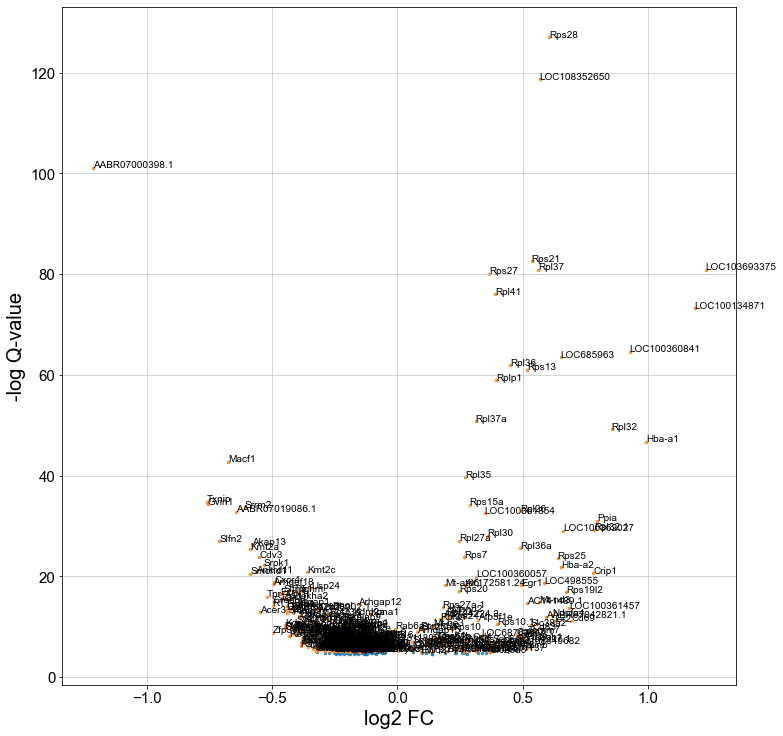

In [49]:
#Volcano plot of results
ent_de['-logQ'] = -np.log(ent_de['FDR'])
lowqval_de = ent_de.loc[ent_de['-logQ'] > 5]
other_de = ent_de.loc[ent_de['-logQ'] < 5]

fig, ax = plt.subplots(figsize=(12,12))
sns.regplot(other_de['coef'], other_de['-logQ'], fit_reg=False, scatter_kws={'s':6})
sns.regplot(lowqval_de['coef'], lowqval_de['-logQ'], fit_reg=False, scatter_kws={'s':6})
ax.set_xlabel("log2 FC", fontsize=20)
ax.set_ylabel("-log Q-value", fontsize=20)
ax.tick_params(labelsize=15)

# Label names and positions
x = [i for i in lowqval_de['coef']]
y = [i for i in lowqval_de['-logQ']]
labels = lowqval_de['primerid']

# Show only some labels to avoid overcrowding the figure
to_remove = np.where([i < 5 for i in y])[0]
labels = ["" if i in to_remove else lab for i,lab in enumerate(labels) ]

#Move up two labels
y = [y[i]+10 if txt == 'Krt8' else y[i] for i,txt in enumerate(labels)]
y = [y[i]+20 if txt == 'Cd9' else y[i] for i,txt in enumerate(labels)]

#Move down one label
y = [y[i]-20 if txt == 'Phgr1' else y[i] for i,txt in enumerate(labels)]

for i,txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))
plt.show()

In [69]:
ent_de.sort_values(by="coef")

,primerid,Pr(>Chisq),coef,FDR,-logQ
5,Fmod,1.611405e-10,-1.026293,3.896456e-07,14.758028
11,Col14a1,9.769471e-10,-0.895886,1.077928e-06,13.740470
4,AABR07000398.1,1.926237e-10,-0.872987,3.896456e-07,14.758028
89,Plpp3,1.075431e-05,-0.847427,1.466573e-03,6.524827
21,Svil,1.421716e-08,-0.816842,8.216841e-06,11.709325
...,...,...,...,...,...
24,Igfbp3,5.426435e-08,1.559457,2.634426e-05,10.544260
36,Col4a6,3.351513e-07,NaN,1.129925e-04,9.088189
51,Col4a3,2.132179e-06,NaN,5.074167e-04,7.586178
85,Crispld1,9.276419e-06,NaN,1.324563e-03,6.626672
